# Read in raw metadata from the runs and crunch additional metadata

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
import os.path
from glob import glob
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import scmdata
import scmdata.database

from ndcs.constants import PROCESSED_DATA_DIR, NDC_TARGET_RELEASE

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
plt.rcParams["figure.figsize"] = (12, 8)

<IPython.core.display.Javascript object>

In [38]:
SCENARIO_LABELS = {
    "2021-11-09_1__high__C__SSP1BL__exclude": "A",
    "2021-11-09_1__low__U__SSP1BL__exclude": "B",
    "2021-11-09_1__high__C__2030__exclude": "a",
    "2021-11-09_1__high__C__2030__include": "b",
    "2021-11-09_1__low__C__2030__exclude": "c",
    "2021-11-09_1__low__C__2030__include": "d",
    "2021-11-09_1__high__U__2030__exclude": "e",
    "2021-11-09_1__low__U__2030__exclude": "f",
    "2021-11-09_1__high__U__2030__include": "g",
    "2021-11-09_1__low__U__2030__include": "h",
    # Methane scenarios
    "2021-11-03_1__high__C__SSP1BL__exclude__fullCH4": "m",
    "2021-11-03_1__high__C__SSP1BL__exclude__conditionalCH4": "n",
    "2021-11-03_1__high__C__SSP1BL__exclude__unconditionalCH4": "o",
    # A variants
    "2021-11-09_1__high__C__constant__exclude": "A-constant",
    "2021-11-09_1__high__C__rate__exclude": "A-rate",
    "2021-11-09_1__high__C__SSP1BL__include": "A-hot air",
}

<IPython.core.display.Javascript object>

In [6]:
DATE_CODE = "20220114"

<IPython.core.display.Javascript object>

# Fetch data from AWS

In [7]:
CLIMATE_ASSESSMENT_ID = f"{DATE_CODE}-ndc-sensitivity"
DATA_DIR_SENSITIVITY = os.path.join(
    PROCESSED_DATA_DIR, "climate_assessment", CLIMATE_ASSESSMENT_ID
)

!aws s3 sync s3://ipcc-climate-assessment/{CLIMATE_ASSESSMENT_ID}/merged {DATA_DIR_SENSITIVITY}
!aws s3 sync s3://ipcc-climate-assessment/{CLIMATE_ASSESSMENT_ID}/out/raw_climate_output/ {DATA_DIR_SENSITIVITY}/raw_climate_output/

meta_files = glob(os.path.join(DATA_DIR_SENSITIVITY, "results_*.csv"))
meta_raw_sensitivity = pd.read_csv(sorted(meta_files)[-1])

<IPython.core.display.Javascript object>

In [8]:
CLIMATE_ASSESSMENT_ID = f"{DATE_CODE}-ndc-methanePledges"
DATA_DIR_METHANE = os.path.join(
    PROCESSED_DATA_DIR, "climate_assessment", CLIMATE_ASSESSMENT_ID
)

!aws s3 sync s3://ipcc-climate-assessment/{CLIMATE_ASSESSMENT_ID}/merged {DATA_DIR_METHANE}
!aws s3 sync s3://ipcc-climate-assessment/{CLIMATE_ASSESSMENT_ID}/out/raw_climate_output/ {DATA_DIR_METHANE}/raw_climate_output/

meta_files = glob(os.path.join(DATA_DIR_METHANE, "results_*.csv"))
meta_raw_methane = pd.read_csv(sorted(meta_files)[-1])

<IPython.core.display.Javascript object>

In [9]:
# Note that the datecode is different
CLIMATE_ASSESSMENT_ID = f"20220113-ndc-complete"
DATA_DIR_COMPLETE = os.path.join(
    PROCESSED_DATA_DIR, "climate_assessment", CLIMATE_ASSESSMENT_ID
)

!aws s3 sync s3://ipcc-climate-assessment/{CLIMATE_ASSESSMENT_ID}/merged {DATA_DIR_COMPLETE}


meta_files = glob(os.path.join(DATA_DIR_COMPLETE, "results_*.csv"))
meta_raw_complete = pd.read_csv(sorted(meta_files)[-1])

<IPython.core.display.Javascript object>

In [61]:
def resolve_scenario_meta(df):
    out = []

    # Resolve metadata from scenario name
    for s in df.groupby("scenario"):
        try:
            (
                pathway_id,
                ambition,
                conditionality,
                extension,
                exclude_hot_air,
            ) = s.get_unique_meta("scenario", True).split("__")
            methane_pledges = ""
        except:
            (
                pathway_id,
                ambition,
                conditionality,
                extension,
                exclude_hot_air,
                methane_pledges,
            ) = s.get_unique_meta("scenario", True).split("__")

        s["pathway_id"] = pathway_id
        s["ambition"] = ambition
        s["conditionality"] = conditionality
        s["country_extension"] = extension
        s["exclude_hot_air"] = exclude_hot_air
        s["methane_pledges"] = methane_pledges

        out.append(s)

    return scmdata.run_append(out)

<IPython.core.display.Javascript object>

# Load meta and calculate additional percentiles

In [40]:
meta_raw = pd.concat([meta_raw_sensitivity, meta_raw_methane]).reset_index(drop=True)
meta_raw["label"] = [SCENARIO_LABELS.get(s, "") for s in meta_raw["scenario"]]
meta_raw.head()

,model,scenario,exclude,Exceedance Probability 1.5C (MAGICCv7.5.3),Exceedance Probability 2.0C (MAGICCv7.5.3),Exceedance Probability 2.5C (MAGICCv7.5.3),Exceedance Probability 3.0C (MAGICCv7.5.3),...,Category,Category_name,harmonization,infilling,climate-models,pipeline,label
0,NDC Factsheet,2021-11-09_1__low__C__rate__exclude,False,0.933333,0.526667,0.170000,0.051667,...,C5,C5: Below 2.5°C,aneris (version: 0.2.0+41.g6ddf6e5),silicone (version: 1.2.1),openscm_runner (version: 0.9.1),climate-assessment (version: 0.1.3-fgd+24.g0f1ec01),
1,NDC Factsheet,2021-11-09_1__low__C__rate__include,False,0.970000,0.660000,0.251667,0.093333,...,C5,C5: Below 2.5°C,aneris (version: 0.2.0+41.g6ddf6e5),silicone (version: 1.2.1),openscm_runner (version: 0.9.1),climate-assessment (version: 0.1.3-fgd+24.g0f1ec01),
2,NDC Factsheet,2021-11-09_1__high__U__constant__exclude,False,0.903333,0.416667,0.121667,0.018333,...,C4,C4: Below 2°C,aneris (version: 0.2.0+41.g6ddf6e5),silicone (version: 1.2.1),openscm_runner (version: 0.9.1),climate-assessment (version: 0.1.3-fgd+24.g0f1ec01),
3,NDC Factsheet,2021-11-09_1__high__U__constant__include,False,0.921667,0.471667,0.136667,0.030000,...,C4,C4: Below 2°C,aneris (version: 0.2.0+41.g6ddf6e5),silicone (version: 1.2.1),openscm_runner (version: 0.9.1),climate-assessment (version: 0.1.3-fgd+24.g0f1ec01),
4,NDC Factsheet,2021-11-09_1__high__C__2030__exclude,False,0.975000,0.693333,0.280000,0.108333,...,C5,C5: Below 2.5°C,aneris (version: 0.2.0+41.g6ddf6e5),silicone (version: 1.2.1),openscm_runner (version: 0.9.1),climate-assessment (version: 0.1.3-fgd+24.g0f1ec01),a


<IPython.core.display.Javascript object>

In [41]:
meta_raw[meta_raw.label.isin(["A", "B"])].T

,12,24
model,NDC Factsheet,NDC Factsheet
scenario,2021-11-09_1__low__U__SSP1BL__exclude,2021-11-09_1__high__C__SSP1BL__exclude
exclude,False,False
Exceedance Probability 1.5C (MAGICCv7.5.3),0.935,0.898333
Exceedance Probability 2.0C (MAGICCv7.5.3),0.523333,0.421667
Exceedance Probability 2.5C (MAGICCv7.5.3),0.17,0.123333
Exceedance Probability 3.0C (MAGICCv7.5.3),0.05,0.02
p33 peak warming (MAGICCv7.5.3),1.855377,1.755587
median peak warming (MAGICCv7.5.3),2.03217,1.918541
p67 peak warming (MAGICCv7.5.3),2.224263,2.085502


<IPython.core.display.Javascript object>

In [42]:
# drop peak warming and year of peak warming stats as they will be recalculated
cols = [
    c
    for c in meta_raw.columns
    if ("peak warming" not in c and "warming in 2100" not in c)
]
meta = meta_raw[cols]
cols = [c.replace("(MAGICCv7.5.3)", "") for c in cols]
meta.columns = cols
meta.head()

,model,scenario,exclude,Exceedance Probability 1.5C,Exceedance Probability 2.0C,Exceedance Probability 2.5C,Exceedance Probability 3.0C,Category,Category_name,harmonization,infilling,climate-models,pipeline,label
0,NDC Factsheet,2021-11-09_1__low__C__rate__exclude,False,0.933333,0.526667,0.170000,0.051667,C5,C5: Below 2.5°C,aneris (version: 0.2.0+41.g6ddf6e5),silicone (version: 1.2.1),openscm_runner (version: 0.9.1),climate-assessment (version: 0.1.3-fgd+24.g0f1ec01),
1,NDC Factsheet,2021-11-09_1__low__C__rate__include,False,0.970000,0.660000,0.251667,0.093333,C5,C5: Below 2.5°C,aneris (version: 0.2.0+41.g6ddf6e5),silicone (version: 1.2.1),openscm_runner (version: 0.9.1),climate-assessment (version: 0.1.3-fgd+24.g0f1ec01),
2,NDC Factsheet,2021-11-09_1__high__U__constant__exclude,False,0.903333,0.416667,0.121667,0.018333,C4,C4: Below 2°C,aneris (version: 0.2.0+41.g6ddf6e5),silicone (version: 1.2.1),openscm_runner (version: 0.9.1),climate-assessment (version: 0.1.3-fgd+24.g0f1ec01),
3,NDC Factsheet,2021-11-09_1__high__U__constant__include,False,0.921667,0.471667,0.136667,0.030000,C4,C4: Below 2°C,aneris (version: 0.2.0+41.g6ddf6e5),silicone (version: 1.2.1),openscm_runner (version: 0.9.1),climate-assessment (version: 0.1.3-fgd+24.g0f1ec01),
4,NDC Factsheet,2021-11-09_1__high__C__2030__exclude,False,0.975000,0.693333,0.280000,0.108333,C5,C5: Below 2.5°C,aneris (version: 0.2.0+41.g6ddf6e5),silicone (version: 1.2.1),openscm_runner (version: 0.9.1),climate-assessment (version: 0.1.3-fgd+24.g0f1ec01),a


<IPython.core.display.Javascript object>

In [43]:
db_sensitivity = scmdata.database.ScmDatabase(
    os.path.join(DATA_DIR_SENSITIVITY, "raw_climate_output"),
    ["climate_model", "variable", "model", "scenario"],
)
db_sensitivity

<scmdata.database.SCMDatabase (root_dir: /home/jared/code/cr/ndc-realisations-2021/src/ndcs/../../data/processed/climate_assessment/20220114-ndc-sensitivity/raw_climate_output, levels: ('climate_model', 'variable', 'model', 'scenario'))>

<IPython.core.display.Javascript object>

In [44]:
db_methane = scmdata.database.ScmDatabase(
    os.path.join(DATA_DIR_METHANE, "raw_climate_output"),
    ["climate_model", "variable", "model", "scenario"],
)

<IPython.core.display.Javascript object>

In [45]:
temperatures_raw = scmdata.run_append([db_sensitivity.load(variable="Raw Surface Temperature (GSAT)"),db_methane.load(variable="Raw Surface Temperature (GSAT)")])

HIST_TEMP_REF_PERIOD = range(1850, 1900 + 1)
HIST_TEMP_EVALUATION_PERIOD = range(1995, 2014 + 1)
HIST_TEMP_ASSESSMENT_CENTRAL = 0.85

temperatures = temperatures_raw.relative_to_ref_period_mean(
    year=HIST_TEMP_REF_PERIOD
).drop_meta(["reference_period_start_year", "reference_period_end_year"])


Loading files:   0%|          | 0/32 [00:00<?, ?it/s]

Loading files:   0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [62]:
temperatures = resolve_scenario_meta(temperatures)

<IPython.core.display.Javascript object>

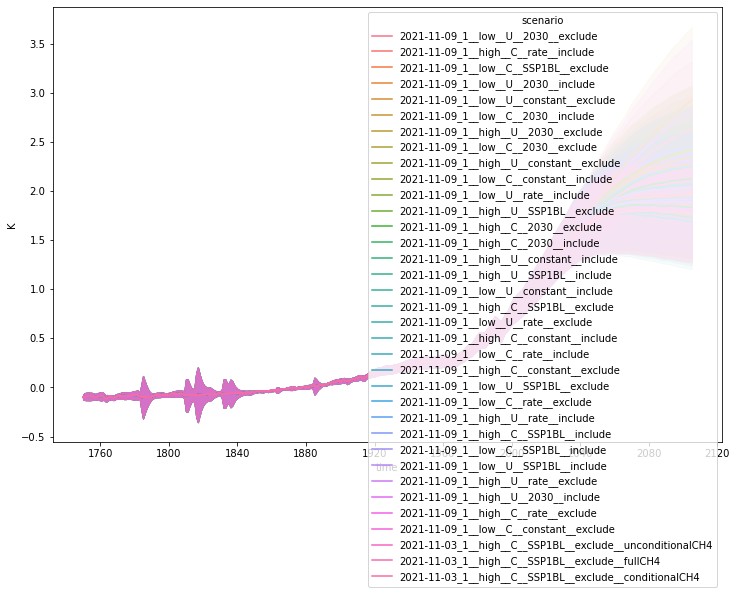

<IPython.core.display.Javascript object>

In [46]:
temperatures.line_plot(hue="scenario")

In [47]:
temperatures = temperatures.adjust_median_to_target(
    HIST_TEMP_ASSESSMENT_CENTRAL,
    HIST_TEMP_EVALUATION_PERIOD,
    process_over=("run_id",),
).filter(year=range(2000, 2101))

<IPython.core.display.Javascript object>

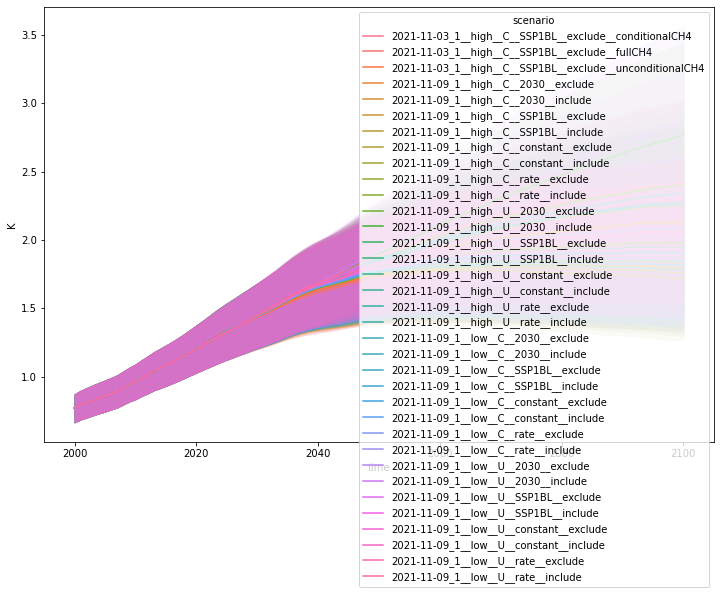

<IPython.core.display.Javascript object>

In [48]:
temperatures.line_plot(hue="scenario")

In [49]:
percentiles = (
    (0.05, "p5"),
    (0.37, "p37"),
    (0.50, "median"),
    (0.67, "p67"),
    (0.95, "p95"),
)

<IPython.core.display.Javascript object>

In [63]:
stats = []

hist_temp_grouper_cols = temperatures.get_meta_columns_except("run_id")

for r in temperatures.groupby("scenario"):
    scenario_stats = {
        "scenario": r.get_unique_meta("scenario", True),
        "pathway_id": r.get_unique_meta("pathway_id", True),
        "ambition": r.get_unique_meta("ambition", True),
        "conditionality": r.get_unique_meta("conditionality", True),
        "country_extension": r.get_unique_meta("country_extension", True),
        "exclude_hot_air": r.get_unique_meta("exclude_hot_air", True),
        "methane_pledges": r.get_unique_meta("methane_pledges", True),
    }

    for p, p_long in percentiles:
        scenario_stats["{} peak warming".format(p_long)] = (
            r.timeseries().max(axis=1).quantile(p)
        )

    for p, p_long in percentiles:
        scenario_stats["{} year of peak warming".format(p_long)] = (
            r.timeseries().idxmax(axis=1).quantile(p).year
        )

    for p, p_long in percentiles:
        scenario_stats["{} warming in 2100".format(p_long)] = (
            r.filter(year=2100).timeseries().squeeze().quantile(p)
        )
    stats.append(scenario_stats)
stats = pd.DataFrame(stats).set_index("scenario")

<IPython.core.display.Javascript object>

In [64]:
stats.loc["2021-11-09_1__high__C__SSP1BL__exclude"]

pathway_id                     2021-11-09_1
ambition                               high
conditionality                            C
country_extension                    SSP1BL
exclude_hot_air                     exclude
methane_pledges                            
p5 peak warming                    1.258223
p37 peak warming                   1.706483
median peak warming                1.829449
p67 peak warming                    2.03443
p95 peak warming                   2.775982
p5 year of peak warming                2049
p37 year of peak warming               2075
median year of peak warming            2081
p67 year of peak warming               2089
p95 year of peak warming               2100
p5 warming in 2100                 1.210884
p37 warming in 2100                1.660001
median warming in 2100             1.799647
p67 warming in 2100                2.010348
p95 warming in 2100                2.771222
Name: 2021-11-09_1__high__C__SSP1BL__exclude, dtype: object

<IPython.core.display.Javascript object>

In [66]:
merged = pd.merge(meta, stats, left_on="scenario", right_on="scenario")

<IPython.core.display.Javascript object>

In [73]:
merged_cols = [
    "model",
    "scenario",
    "label",
    "ambition",
    "conditionality",
    "country_extension",
    "exclude_hot_air",
    "methane_pledges",
    "Category",
    "Category_name",
    "Exceedance Probability 1.5C ",
    "Exceedance Probability 2.0C ",
    "Exceedance Probability 2.5C ",
    "Exceedance Probability 3.0C ",
    "p5 peak warming",
    "p37 peak warming",
    "median peak warming",
    "p67 peak warming",
    "p95 peak warming",
    "p5 year of peak warming",
    "p37 year of peak warming",
    "median year of peak warming",
    "p67 year of peak warming",
    "p95 year of peak warming",
    "p5 warming in 2100",
    "p37 warming in 2100",
    "median warming in 2100",
    "p67 warming in 2100",
    "p95 warming in 2100",
    "harmonization",
    "infilling",
    "climate-models",
    "pipeline",
]

<IPython.core.display.Javascript object>

In [74]:
merged[merged_cols].round(3).to_csv(
    os.path.join(PROCESSED_DATA_DIR, "stats_{}.csv".format(NDC_TARGET_RELEASE)),
    index=False,
)

<IPython.core.display.Javascript object>

In [75]:
short_cols = [
    "scenario",
    "Category",
    "Category_name",
    "label",
    "ambition",
    "conditionality",
    "country_extension",
    "exclude_hot_air",
    "methane_pledges",
    "Exceedance Probability 1.5C ",
    "Exceedance Probability 2.0C ",
    "Exceedance Probability 2.5C ",
    "Exceedance Probability 3.0C ",
    "p5 peak warming",
    "median peak warming",
    "p95 peak warming",
    "p5 year of peak warming",
    "median year of peak warming",
    "p95 year of peak warming",
    "p5 warming in 2100",
    "median warming in 2100",
    "p95 warming in 2100",
]

<IPython.core.display.Javascript object>

In [76]:
merged[merged.label != ""][short_cols].round(3).sort_values("label").to_csv(
    os.path.join(PROCESSED_DATA_DIR, "stats_{}_short.csv".format(NDC_TARGET_RELEASE)),
    index=False,
)

<IPython.core.display.Javascript object>

# Combine output into a single file

In [26]:
def parse_quantiles(results):
    results_cleaned_list = []
    for var_name in results.get_unique_meta("variable"):
        subset = results.filter(variable=var_name)

        tokens = var_name.split("|")
        subset["variable"] = "|".join(tokens)

        if "Percentile" in var_name:
            subset["variable"] = "|".join(tokens[:-1])
            quantile = float(tokens[-1][: -len("th Percentile")])

            subset["quantile"] = quantile / 100
        results_cleaned_list.append(subset)
    return scmdata.run_append(results_cleaned_list)


def make_summary_database(data_dir):
    alloutput_files = glob(os.path.join(data_dir, "*_alloutput.xlsx"))

    alloutput_merged = scmdata.run_append(
        [scmdata.ScmRun(f, lowercase_cols=True) for f in tqdm(alloutput_files)]
    )
    alloutput_cleaned = resolve_scenario_meta(alloutput_merged)

    # Strip variable names
    alloutput_cleaned["variable"] = [
        v[len("AR6 climate diagnostics|") :] for v in alloutput_merged["variable"]
    ]
    alloutput_cleaned = parse_quantiles(alloutput_cleaned)
    alloutput_cleaned["label"] = [
        SCENARIO_LABELS.get(s, "") for s in alloutput_cleaned["scenario"]
    ]

    return alloutput_cleaned


make_summary_database(DATA_DIR_METHANE).head()

  0%|          | 0/2 [00:00<?, ?it/s]

time                                                                                                                                                                                                                                   1995-01-01  \
ambition conditionality country_extension exclude_hot_air label methane_pledges  model         pathway_id   quantile region scenario                                                 unit variable                                                  
high     C              SSP1BL            exclude               conditionalCH4   NDC Factsheet 2021-11-03_1 0.100    World  2021-11-03_1__high__C__SSP1BL__exclude__conditionalCH4   ppb  Atmospheric Concentrations|CH4|MAGICCv7.5.3     1755.23   
                                                                fullCH4          NDC Factsheet 2021-11-03_1 0.100    World  2021-11-03_1__high__C__SSP1BL__exclude__fullCH4          ppb  Atmospheric Concentrations|CH4|MAGICCv7.5.3     1755.23   
                                                                unconditionalCH4 NDC Factsheet 2021-11-03_1 0.100    World  2021-11-03_1__high__C__SSP1BL__exclude__unconditionalCH4 ppb  Atmospheric Concentrations|CH4|MAGICCv7.5.3     1755.23   
                                                                conditionalCH4   NDC Factsheet 2021-11-03_1 0.167    World  2021-11-03_1__high__C__SSP1BL__exclude__conditionalCH4   ppb  Atmospheric Concentrations|CH4|MAGICCv7.5.3     1755.23   
                                                                fullCH4          NDC Factsheet 2021-11-03_1 0.167    World  2021-11-03_1__high__C__SSP1BL__exclude__fullCH4          ppb  Atmospheric Concentrations|CH4|MAGICCv7.5.3     1755.23   

time                                                                                                                                                                                                                                   1996-01-01  \
ambition conditionality country_extension exclude_hot_air label methane_pledges  model         pathway_id   quantile region scenario                                                 unit variable                                                  
high     C              SSP1BL            exclude               conditionalCH4   NDC Factsheet 2021-11-03_1 0.100    World  2021-11-03_1__high__C__SSP1BL__exclude__conditionalCH4   ppb  Atmospheric Concentrations|CH4|MAGICCv7.5.3     1757.19   
                                                                fullCH4          NDC Factsheet 2021-11-03_1 0.100    World  2021-11-03_1__high__C__SSP1BL__exclude__fullCH4          ppb  Atmospheric Concentrations|CH4|MAGICCv7.5.3     1757.19   
                                                                unconditionalCH4 NDC Factsheet 2021-11-03_1 0.100    World  2021-11-03_1__high__C__SSP1BL__exclude__unconditionalCH4 ppb  Atmospheric Concentrations|CH4|MAGICCv7.5.3     1757.19   
                                                                conditionalCH4   NDC Factsheet 2021-11-03_1 0.167    World  2021-11-03_1__high__C__SSP1BL__exclude__conditionalCH4   ppb  Atmospheric Concentrations|CH4|MAGICCv7.5.3     1757.19   
                                                                fullCH4          NDC Factsheet 2021-11-03_1 0.167    World  2021-11-03_1__high__C__SSP1BL__exclude__fullCH4          ppb  Atmospheric Concentrations|CH4|MAGICCv7.5.3     1757.19   

time                                                                                                                                                                                                                                   1997-01-01  \
ambition conditionality country_extension exclude_hot_air label methane_pledges  model         pathway_id   quantile region scenario                                                 unit variable                                                  
high     C              SSP1BL            exclude               conditionalCH4

<IPython.core.display.Javascript object>

In [27]:
DATA_DIR = os.path.join(PROCESSED_DATA_DIR, "climate_assessment", "merged")

<IPython.core.display.Javascript object>

In [39]:
for (input_data_dir, name) in (
    (DATA_DIR_SENSITIVITY, "sensitivity"),
    (DATA_DIR_METHANE, "methanePledges"),
    (DATA_DIR_COMPLETE, "complete"),
):
    summary = make_summary_database(input_data_dir)
    out_fname = os.path.join(DATA_DIR, f"output_{NDC_TARGET_RELEASE}_{name}.csv")
    os.makedirs(os.path.dirname(out_fname), exist_ok=True)
    summary.to_csv(out_fname)

  0%|          | 0/2 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

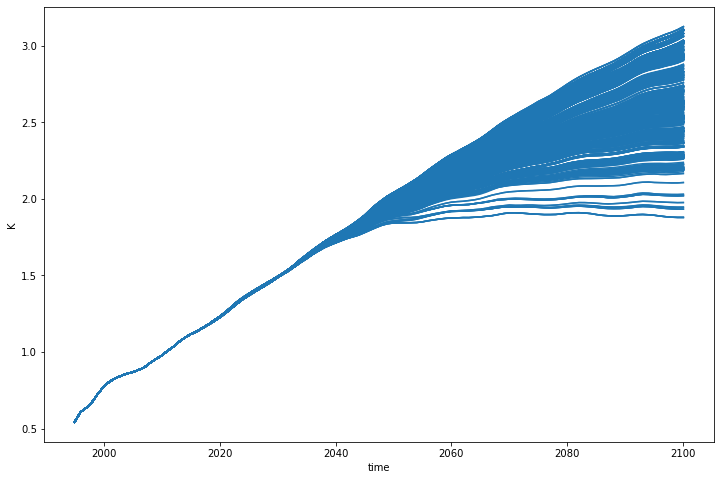

<IPython.core.display.Javascript object>

In [29]:
for v in ["Surface Temperature (GSAT)|MAGICCv7.5.3"]:
    plt.figure()

    summary.filter(variable=v, quantile=0.5).lineplot(
        hue="variable", estimator=None, units="scenario", legend=False
    )